# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable

## Introduction
The aim of this project, provided by the Project Urban Co-creation Data lab, is to identify patterns in illegal parking in Vancouver and build a predictive model.   
We were are able to build two predictive models of illegal parking using time series forecasting and random forest classification algorithms. These models can provide insights into the effect of the date and the street location on unlawful parking. 

## Development

### Initialize

In [135]:
# Mount the drive folder
from google.colab import drive # to load data from google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import os # For files operations
import warnings
import itertools
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import urllib.request # For download from url
import matplotlib.pyplot as plt # ploting the data
import seaborn as sns # ploting the data
import csv # to import data in txt files
from datetime import datetime
import plotly.express as px
import folium

In [137]:
# to use Panda profilling
# See the output to NULL for notebook readibility
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip > NULL
from pandas_profiling import ProfileReport

In [138]:
!pip install geopandas > NULL
import geopandas

In [139]:
# Set up color blind friendly color palette
# The palette with grey:
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# The palette with black:
cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# sns.palplot(sns.color_palette(cbPalette))
# sns.palplot(sns.color_palette(cbbPalette))

sns.set_palette(cbPalette)
#sns.set_palette(cbbPalette)

In [140]:
# Seaborn plot shortcuts
def boxplot(data, x, y, title = ""):
    
    """
    This function generates a seaborn boxplot with my defaults parameters.

    Parameters:
        title (string) title of the plot, default is empty
        data (df) the data frame
        x (panda serie) the x axis
        y (panda serie) the y axis
    """

    f, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x=x, y=y, data=data, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
    plt.title(title)
    plt.ioff()

def countplot(data, variable, title = ""):
    """
    This function contains my favourite parameters for the seaborn coutplot plot
    """

    f, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(data=data, x=variable)
    plt.title(title)
    plt.ioff()

In [141]:
# Set up the path for the data and output folders
PATH = "/content/drive/MyDrive/Data_science/WDL/Stage2/Irregular_Parking/"
data = PATH + "Data"

output = PATH + "Output"

### Exploratory Data Analysis


In [142]:
file = data + "/" + "merged_parking.csv"
parking_data=pd.read_csv(file) #read the data
parking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35477 entries, 0 to 35476
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      35477 non-null  int64  
 1   Block           35477 non-null  int64  
 2   Street          35477 non-null  object 
 3   EntryDate       35477 non-null  object 
 4   Bylaw           35477 non-null  int64  
 5   Section         35477 non-null  object 
 6   Status          35477 non-null  object 
 7   InfractionText  35477 non-null  object 
 8   Year            35477 non-null  float64
 9   HBLOCK          35477 non-null  object 
 10  STREETUSE       35477 non-null  object 
 11  coord_1         35477 non-null  object 
 12  coord_2         35477 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 3.5+ MB


In [143]:
parking_data.head()#get the first 5 rows 

,Unnamed: 0,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK,STREETUSE,coord_1,coord_2
0,0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"
1,1,1400,KINGSWAY,2018-07-25,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2018.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"
2,2,1400,KINGSWAY,2019-07-03,2849,19.1(G),VA,STOP ON A LANE WITHIN AN AREA 1.5M FROM EITHER...,2019.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"
3,3,1400,KINGSWAY,2018-01-08,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2018.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"
4,4,1400,KINGSWAY,2018-01-04,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2018.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"


In [144]:
# Generate and save an automated EDA report
file = output + "/" + "parking_dataset_EDA.html"
report = ProfileReport(parking_data)
report.to_file(output_file=file)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [145]:
# Display the report
report.to_notebook_iframe()

The keys takeaway from the EDA are:

* The dataset does not contain missing values
* The RA status only represents 7 observation and should probably be removed for classification models.
* PARK IN A METERED SPACE is the leading cause of infraction. 
* Most of the infractions are committed in Arterial areas. 

### Data cleaning

In [146]:
data = ['InfractionText','Street','Status','HBLOCK','STREETUSE']#Gather the data that needs to be converted into numerical values

In [147]:
#Convertion of the string objects into numerical values
for column in data:
    ord_enc = OrdinalEncoder()
    parking_data[column] = ord_enc.fit_transform(parking_data[[column]])

In [148]:
#Focusing on these two variables for the analysis
X = parking_data['EntryDate']
Y = parking_data['InfractionText']

In [149]:
new_data = [X,Y]#Creates a list to input the dataframe

In [150]:
df = pd.DataFrame(new_data).T#creates a new dataframe with the values needed for analysis and transform to create rows

In [151]:
df['EntryDate'] = pd.to_datetime(df['EntryDate'],infer_datetime_format=True)#Convert the entrydate to date object

In [152]:
total_infractions = df.groupby(["EntryDate"])['InfractionText'].count()#count the total number of infractions per date for analysis
type(total_infractions)

pandas.core.series.Series

In [153]:
total_infra_df= pd.DataFrame(total_infractions)#Convert the series into dataframe
total_infra_df.columns =['TotalInfractions']#rename the columns for better understanding
total_infra_df

,TotalInfractions
EntryDate,
2017-01-03,1
2017-01-05,7
2017-01-06,12
2017-01-09,1
2017-01-11,2
...,...
2019-11-29,409
2019-12-12,166
2019-12-28,342


### Time series analysis

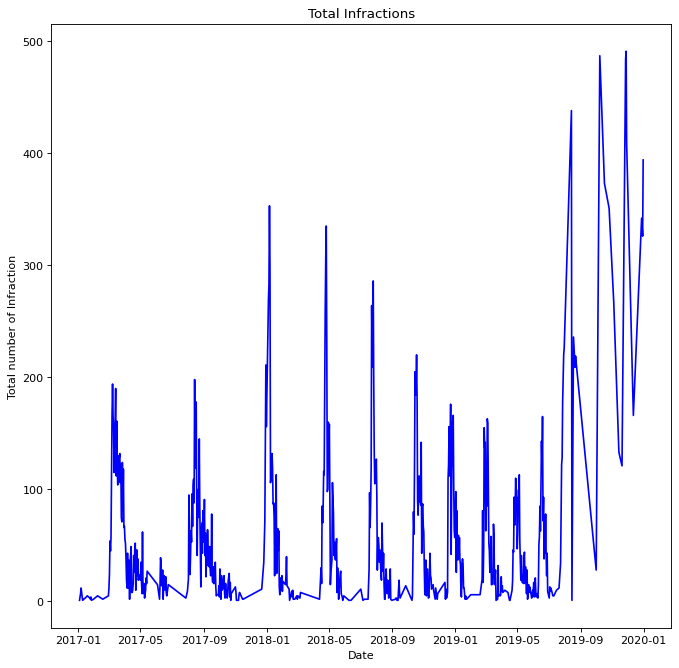

In [154]:
#This plot is to visualize the total number of infractions
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(total_infra_df, color='blue')
plt.xlabel('Date')
plt.ylabel('Total number of Infraction')
plt.title("Total Infractions")
plt.show()

The graph above shows the total infractions per year

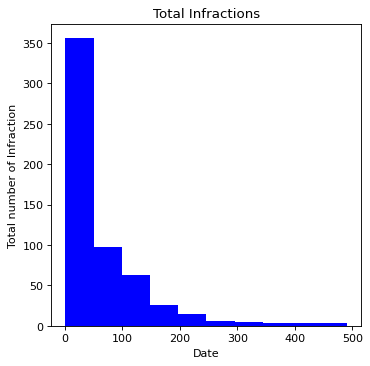

In [155]:
#Visualize a histogram to determine the skewedness
plt.figure(figsize=(5, 5), dpi=80)
plt.hist(total_infra_df['TotalInfractions'], color='blue')
plt.xlabel('Date')
plt.ylabel('Total number of Infraction')
plt.title("Total Infractions")
plt.show()

From the graph below, we can see that the graph is skewed to the right

#### Check for stationarity, seasonaility and trend

rollling statistics method

In [156]:
total_infractions_mean = total_infra_df.rolling(window=12).mean()#mean for 12 month window
total_infractions_std = total_infra_df.rolling(window=12).std()#standard deviation for 12 month window
total_infractions_mean=total_infractions_mean.dropna()#drop all the nan values
total_infractions_std=total_infractions_std.dropna()

Text(0, 0.5, 'Infractions per year')

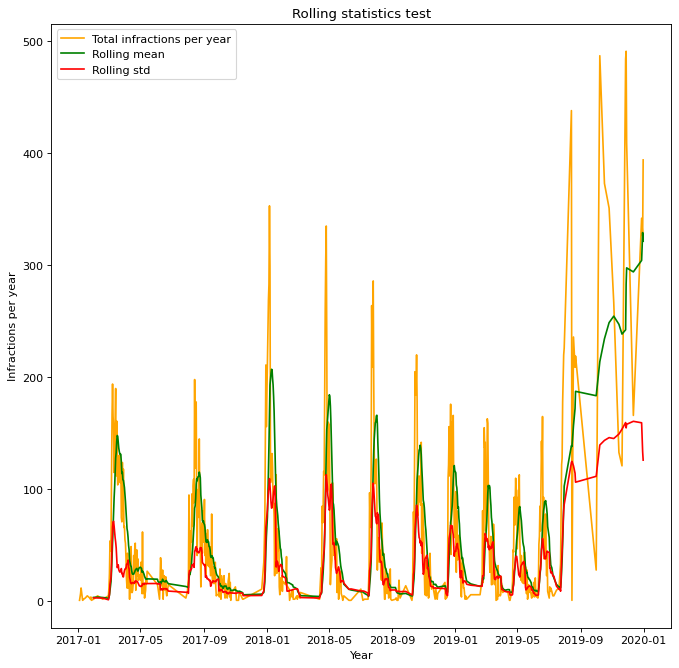

In [157]:
#Plot to display the rolling mean and std
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(total_infractions,color='orange',label='Total infractions per year')
plt.plot(total_infractions_mean,color='green',label='Rolling mean')
plt.plot(total_infractions_std,color='red',label='Rolling std')
plt.legend()
plt.title("Rolling statistics test")
plt.xlabel('Year')
plt.ylabel('Infractions per year')

From analysing the plot above,its clear that the rolling mean and std are close to the original plot,so further test is done to understand the stationarity

Method two Dickey–Fuller test

In [158]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [159]:
result = adfuller(total_infra_df['TotalInfractions'])#Gather the result for the dickey fuller test
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.769867
p-value: 0.003231
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


From analysing the p-value, its 0.003 which is less than 0.05.This indicates that the data is stationary enough for the time series analysis task.The critical values are closer to the ADG statistic but it would be good for the ADF statistic to be a bit higher aswell.



In [160]:
#Check for seasonality, trends and residue
decomposition = seasonal_decompose(x=total_infra_df['TotalInfractions'], extrapolate_trend='freq', period=int(len(total_infra_df['TotalInfractions'])/2))

TypeError: ignored

In [ ]:
# Plot for the trend
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(decomposition.trend)
plt.xlabel('Date')
plt.ylabel('Total number of Infractions')
plt.title("Trend Graph of the Infractions")
plt.show()

The trend graph : From the above trend graph,its clear that for some amount of time the trend was down and then its high.For eaxmple,September 2017 the infraction rate was quite low however September 2018 the infraction rate is quite high.The trend disappeared after a time

In [ ]:
# Seasonal graph
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(decomposition.seasonal)
plt.xlabel('Date')
plt.ylabel('Total number of Infraction')
plt.title("Seasonality Graph for the Infractions")

plt.show()

Seasonality Graph: From observing this graph, its evident that the infraction rates decreases for the month May. For example: 2017-05,2018-05 and 2019-05. Its quite seasonal as there is quite a lot of fluctuations

In [ ]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(decomposition.resid)
plt.xlabel('Date')
plt.ylabel('Total number of Infractions')
plt.show()

The total number of infractions per year is quite regular in nature.

#### Baseline model
The previous value is the best reflection of the future value series(t+1)

In [ ]:
baseline_df = pd.concat([total_infra_df['TotalInfractions'],total_infra_df-total_infra_df.shift(1)],axis=1)
baseline_df.columns =['Actual_Infraction','Forecast_Infraction']
baseline_df.head()

In [ ]:
baseline_df = baseline_df[1:] 
baseline_mse = mean_squared_error(baseline_df.Actual_Infraction,baseline_df.Forecast_Infraction)
np.sqrt(baseline_mse)
# The mean squared error is quite high,which would be true as we are shifting the infractions by one place which would be the reason for the hight mse

#### ARIMA model without normalising

##### PART ONE : without differencing or shifting

In [161]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [162]:
train = total_infra_df[0:500] # Test data
test = total_infra_df[500:578]

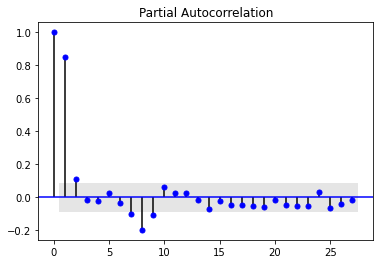

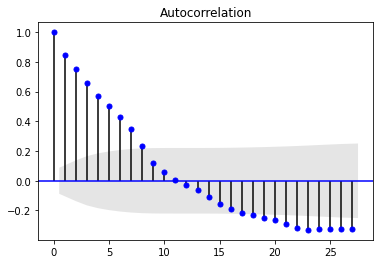

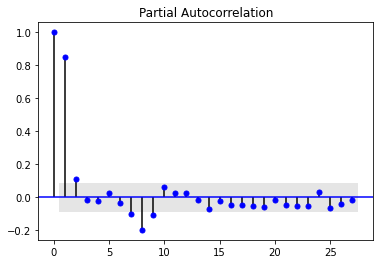

In [163]:
plot_acf(train, color="blue")
plot_pacf(train, color="blue")
# From looking at the plot p (partial autocorrelation) is around 4 and q(autocorrelation) is also around 3

In [164]:
arima_model1 =ARIMA(train.TotalInfractions,order = (4,1,3))
arima_model1 = arima_model1.fit()
arima_model1.aic
# The aic is high,which indicates the model is performing poorly

4902.602190819171

In [165]:
forecast = arima_model1.forecast(steps=77)[0]

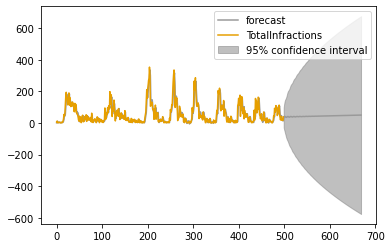

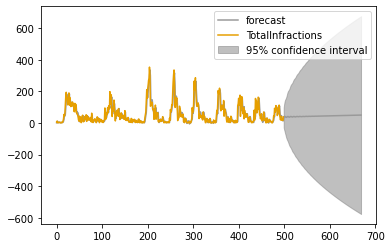

In [166]:
arima_model1.plot_predict(1,670)
# plot with the forecasted line aswell as the range within the 95% confidence interval

In [167]:
np.sqrt(mean_squared_error(test,forecast))
# The mean squared error is quite high meaning the model is poorly fitting the data

ValueError: ignored

##### PART TWO: Differencing and shifting

In [168]:
total_infra_shifted = total_infra_df-total_infra_df.shift(1) # experiment with differencing
total_infra_shifted = total_infra_shifted.dropna()

train2 = total_infra_shifted[0:500] # Test data
test2 = total_infra_shifted[500:577]

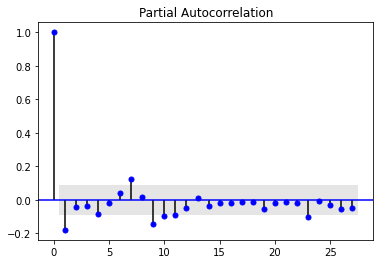

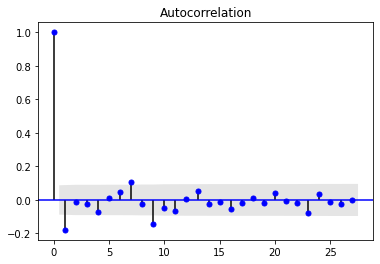

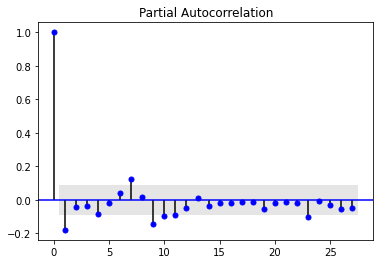

In [169]:
plot_acf(train2, color="blue")
plot_pacf(train2, color="blue")
# From looking at the plot p (partial autocorrelation) is around 1 and q(autocorrelation) is also around 1
# These values are chosen because this is where it drops to 0

In [170]:
arima_model2 =ARIMA(train2.TotalInfractions,order = (1,1,1))
arima_model2 = arima_model2.fit()
arima_model2.aic
# The aic is high,which indicates the model is performing poorly

4917.132111558739

In [171]:
forecast = arima_model2.forecast(steps=77)[0]

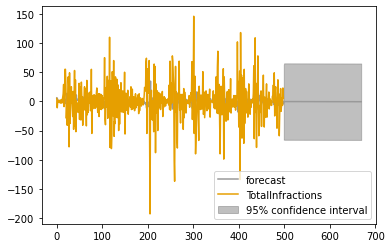

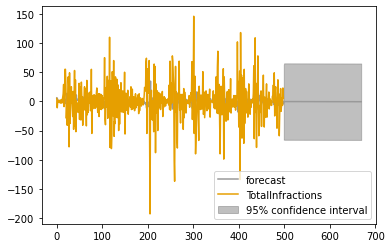

In [172]:
arima_model2.plot_predict(1,670)
# plot with the forecasted line aswell as the range within the 95% confidence interval

In [173]:
np.sqrt(mean_squared_error(test2,forecast))
# The method used is performing poorly as the mean squared error is quite high. The forecasted values are not accurate.

105.09230027162097

#### ARIMA model with normalising

In [175]:
# Normalise the dataset as it contains a big range of values
from sklearn.preprocessing import MinMaxScaler

scaler_model = MinMaxScaler(feature_range=(0,1))
scaler_model = scaler_model.fit(total_infra_df)
normalize = scaler_model.transform(total_infra_df)
# normalize

In [176]:
train3 = normalize[0:500]
test3 = normalize[500:578]

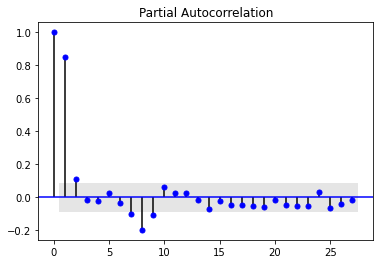

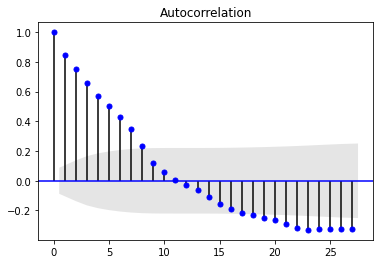

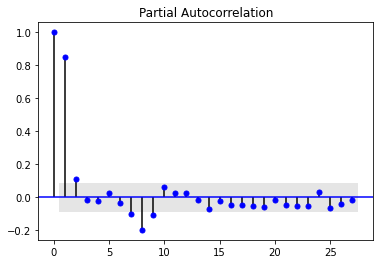

In [177]:
plot_acf(train3, color="blue")
plot_pacf(train3, color="blue")

In [178]:
arima_model3 =ARIMA(train3,order = (4,1,3))
arima_model3 = arima_model3.fit()
arima_model3.aic
# lower aic means better the model.

-1279.4143895028942

In [179]:
forecast = arima_model3.forecast(steps=78)[0]

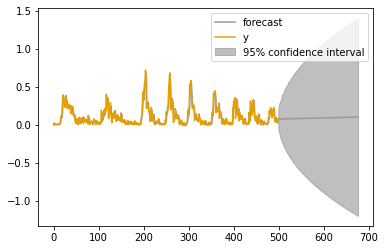

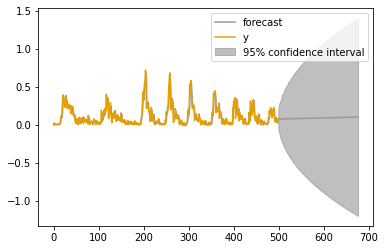

In [180]:
arima_model3.plot_predict(1,677)
# plot with the forecasted line aswell as the range within the 95% confidence interval

In [181]:
model_mse = mean_squared_error(test3,forecast)
np.sqrt(model_mse)
# The normalized data is peromfing better at forecasting compared to without normalised as the mean squared error is quite low

0.30620902338097655

### Random Forest model of infraction types

In [182]:
parking_data["lat_1"]=parking_data["coord_1"].apply(lambda x:x.strip('[').strip(']').split(',')[0])
parking_data["long_1"]=parking_data["coord_1"].apply(lambda x:x.strip('[').strip(']').split(',')[1])
parking_data["lat_2"]=parking_data["coord_2"].apply(lambda x:x.strip('[').strip(']').split(',')[0])
parking_data["long_2"]=parking_data["coord_2"].apply(lambda x:x.strip('[').strip(']').split(',')[1])

In [183]:
geo_cols=[col for col in parking_data.columns if "lat" in col or "long" in col]
for col in geo_cols:
  parking_data[col]=parking_data[col].astype(float)
agg_dataset_status=parking_data.groupby(by='Status').count()
agg_dataset_status

,Unnamed: 0,Block,Street,EntryDate,Bylaw,Section,InfractionText,Year,HBLOCK,STREETUSE,coord_1,coord_2,lat_1,long_1,lat_2,long_2
Status,,,,,,,,,,,,,,,,
0.0,32428,32428,32428,32428,32428,32428,32428,32428,32428,32428,32428,32428,32428,32428,32428,32428
1.0,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
2.0,2367,2367,2367,2367,2367,2367,2367,2367,2367,2367,2367,2367,2367,2367,2367,2367
3.0,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95
4.0,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580


In [184]:
fig = px.bar(x=agg_dataset_status.index,y=agg_dataset_status.iloc[:,0],text=agg_dataset_status.iloc[:,0],title='Count of Infractions by Status')
fig.show()

In [185]:
datetime.strptime(parking_data.loc[0,"EntryDate"], '%Y-%m-%d')

datetime.datetime(2017, 8, 23, 0, 0)

In [186]:
parking_data["EntryDate"]=parking_data["EntryDate"].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
parking_data["EntryDate"]

0       2017-08-23
1       2018-07-25
2       2019-07-03
3       2018-01-08
4       2018-01-04
           ...    
35472   2019-12-12
35473   2019-12-12
35474   2019-12-12
35475   2019-12-12
35476   2019-12-12
Name: EntryDate, Length: 35477, dtype: datetime64[ns]

In [187]:
parking_data["Month"]=parking_data["EntryDate"].apply(lambda x:x.month)
parking_data["EntryDate"].dt.to_period('M').iloc[0]

Period('2017-08', 'M')

In [188]:
agg_data_month_every_year=parking_data.groupby(by=parking_data["EntryDate"].dt.to_period('M')).count()

In [189]:
fig = px.line(x=agg_data_month_every_year.index.astype('datetime64[ns]'),
              y=agg_data_month_every_year.iloc[:,0],title='Count of Infractions by Month each year')                  #,range_x=['2017-01-01','2019-12-1'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

The top anomaly detected on Oct 8, 2019 was:

Total count of Infractionts is 487, which was higher than the expected 105

In [190]:
agg_date_street_use=parking_data.groupby(by='STREETUSE').count()
agg_date_street_use

,Unnamed: 0,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK,coord_1,coord_2,lat_1,long_1,lat_2,long_2,Month
STREETUSE,,,,,,,,,,,,,,,,,
0.0,21888,21888,21888,21888,21888,21888,21888,21888,21888,21888,21888,21888,21888,21888,21888,21888,21888
1.0,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59
2.0,12771,12771,12771,12771,12771,12771,12771,12771,12771,12771,12771,12771,12771,12771,12771,12771,12771
3.0,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759


In [191]:
fig = px.bar(x=agg_date_street_use.index,
             y=agg_date_street_use.iloc[:,0],title='Count of Infractions by Street Use',
             text=agg_date_street_use.iloc[:,0])
fig.show()

In [209]:
agg_data_street=parking_data.groupby(by="Street").count()
top_20_streets=agg_data_street.apply(lambda x: x.sort_values(ascending=False)).head(20)

Top 20 Streets with the highest number of parking infractions

In [210]:
list(top_20_streets.index)

[449.0,
 360.0,
 359.0,
 199.0,
 378.0,
 191.0,
 202.0,
 450.0,
 61.0,
 0.0,
 265.0,
 43.0,
 238.0,
 3.0,
 414.0,
 367.0,
 120.0,
 214.0,
 80.0,
 453.0]

In [211]:
geo_df_1=geopandas.GeoDataFrame(parking_data.loc[:,["Street","lat_1","long_1"]]\
                                                 ,geometry=geopandas.points_from_xy(parking_data.lat_1,parking_data.long_1))

In [213]:
geo_df_2=geopandas.GeoDataFrame(parking_data.loc[:,["Street","lat_2","long_2"]]\
                                                 ,geometry=geopandas.points_from_xy(parking_data.lat_2,parking_data.long_2))

In [214]:
geo_df_1

,Street,lat_1,long_1,geometry
0,246.0,-123.076099,49.250113,POINT (-123.07610 49.25011)
1,238.0,-123.076099,49.250113,POINT (-123.07610 49.25011)
2,238.0,-123.076099,49.250113,POINT (-123.07610 49.25011)
3,238.0,-123.076099,49.250113,POINT (-123.07610 49.25011)
4,238.0,-123.076099,49.250113,POINT (-123.07610 49.25011)
...,...,...,...,...
35472,468.0,-123.073658,49.260948,POINT (-123.07366 49.26095)
35473,468.0,-123.073649,49.261401,POINT (-123.07365 49.26140)
35474,468.0,-123.073655,49.261082,POINT (-123.07366 49.26108)
35475,81.0,-123.069591,49.271412,POINT (-123.06959 49.27141)


In [215]:
geo_df_1_filt=geo_df_1[geo_df_1["Street"].isin(list(top_20_streets.index))]

In [216]:
geo_df_1_filt=geo_df_1_filt.drop_duplicates("Street",keep='last')

In [217]:
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df_1_filt.geometry ]

In [218]:
geo_unique_lis=[list(x) for x in set(tuple(x) for x in geo_df_list)]

In [219]:
geo_unique_lis

[[49.28109785153686, -123.11250751202398],
 [49.274196273341474, -123.12486044367441],
 [49.273734703205385, -123.12747999381172],
 [49.28199625335289, -123.12080340829894],
 [49.2833918793573, -123.10659026549541],
 [49.28793340051277, -123.11978378180704],
 [49.28531489100729, -123.11189381672449],
 [49.27657602283303, -123.12902759891873],
 [49.26504404011783, -123.14570864426071],
 [49.27545341436151, -123.12680124793647],
 [49.29319891816215, -123.13594497024789],
 [49.28107819201969, -123.10757271128858],
 [49.248896616065345, -123.11004822417173],
 [49.237602592017225, -123.04884462165495],
 [49.21905362666441, -123.11677104318774],
 [49.2117632913364, -123.10216458130378],
 [49.26436426258648, -123.18585678274802],
 [49.27779206826449, -123.12719015447645]]

In [220]:
i=0
Map=folium.Map(location=[49.26107966824709, -123.09776706798105],tiles='OpenStreetMap', zoom_start = 12)
for coordinates in geo_unique_lis:
  Map.add_child(folium.Marker(location = coordinates,popup="Street: "+ str(geo_df_1_filt["Street"].iloc[i])))
  i+=1

In [221]:
Map

In [222]:
geo_df_2_filt=geo_df_2[geo_df_2["Street"].isin(list(top_20_streets.index))]
geo_df_2_filt=geo_df_2_filt.drop_duplicates("Street",keep='last')
geo_df_2_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df_2_filt.geometry ]
geo_unique_2_lis=[list(x) for x in set(tuple(x) for x in geo_df_2_list)]

In [223]:
i=0
Map=folium.Map(location=[49.26107966824709, -123.09776706798105],tiles='OpenStreetMap', zoom_start = 12)
for coordinates in geo_unique_2_lis:
  Map.add_child(folium.Marker(location = coordinates,popup="Street: "+ str(geo_df_2_filt["Street"].iloc[i])))
  i+=1

In [224]:
Map

In [225]:
selected_variables = ["Street", "coord_1", "coord_2", "STREETUSE", "Status"]
df_2 = parking_data[selected_variables].copy()
df_2.head()

,Street,coord_1,coord_2,STREETUSE,Status
0,246.0,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",0.0,0.0
1,238.0,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",0.0,0.0
2,238.0,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",0.0,2.0
3,238.0,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",0.0,0.0
4,238.0,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",0.0,0.0


Removing the observations with the RA status as there are only 7 in number !

In [230]:
df_2=df_2[df_2['Status']!='RA']

In [232]:
# Encoding of the categorical variables
# https://www.hackdeploy.com/python-one-hot-encoding-with-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

from sklearn.preprocessing import LabelEncoder
le_street = LabelEncoder()
le_streetuse = LabelEncoder()
le_entrydate = LabelEncoder()
le_coord_1 = LabelEncoder()
le_coord_2 = LabelEncoder()
le_status = LabelEncoder()

df_2['Street'] = le_street.fit_transform(df_2.Street)
df_2['STREETUSE'] = le_streetuse.fit_transform(df_2.STREETUSE)

df_2['coord_1'] = le_coord_1.fit_transform(df_2.coord_1)
df_2['coord_2'] = le_coord_2.fit_transform(df_2.coord_2)
df_2['Status'] = le_status.fit_transform(df_2.Status)

df_2.head()

,Street,coord_1,coord_2,STREETUSE,Status
0,246,903,888,0,0
1,238,903,888,0,0
2,238,903,888,0,2
3,238,903,888,0,0
4,238,903,888,0,0


In [233]:
df_2.Status.value_counts()

0    32428
2     2367
4      580
3       95
1        7
Name: Status, dtype: int64

In [236]:
from collections import Counter
Counter(df_2.Status.values)

Counter({0: 32428, 1: 7, 2: 2367, 3: 95, 4: 580})

In [238]:
# Separate into variables and target variable
X=df_2.iloc[:,0:3].values
y=df_2.iloc[:,4].values

In [239]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [240]:
over = SMOTE(sampling_strategy={0: 32428, 1: 30000, 2: 20000, 3:30000})
# transform the dataset
X, y = over.fit_resample(X, y)

In [241]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [242]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


X_train, y_train = make_classification(n_samples=1000, n_features=3, n_informative=2, n_redundant=0, random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [243]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

*  Our model gives a weighted precision of about 0.80 considering all the classes which means the true positive rate or the  correctly identified occurences of  infractions of each class is 80%  

* The weighted recall of about 0.27 which means 27% of true positives correctly identified in a collection of true positives and false negatives

* The weighted f1-score is 0.11 which is simply the harmonic mean of the above two measures


In [244]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      8107
           1       0.27      1.00      0.42      7500
           2       1.00      0.00      0.00      5000
           3       1.00      0.00      0.00      7500
           4       1.00      0.00      0.00       145

    accuracy                           0.27     28252
   macro avg       0.85      0.20      0.08     28252
weighted avg       0.81      0.27      0.11     28252



## Conclusions

### Scalability and Impact
The illegal parking problem can increase congestions in a city which can lead to an increase in pollution. Therefore building models to predict which dates and streets present the highest risk of illegal parking would allow focusing efforts in critical areas to reduce illicit parking and its environmental impact. 

Limitations:

This dataset only concerns the city of Vancouver and therefore is not necessarily transposable to other cities. 

### Future Work
Creating a dataset with illegal parking observations from different cities could help identify more general patterns.